In [1]:
using LazySets, Plots

┌ Info: Precompiling LazySets [b4f0291d-fe17-52bc-9479-3d1a343d9043]
└ @ Base loading.jl:1273


In [2]:
A = rand(Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.8681088601921764, -0.10864713200533638], [1.0095544686528635, 0.6101258404418567])

In [3]:
B = rand(2, 2) * A

LinearMap{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},Float64,Array{Float64,2}}([0.21172305079068887 0.3057143596858689; 0.013044756240733646 0.16510708987816236], Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.8681088601921764, -0.10864713200533638], [1.0095544686528635, 0.6101258404418567]))

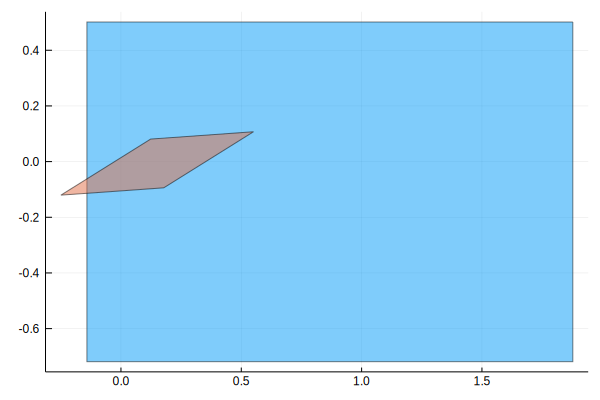

In [4]:
plot([A, B])

In [5]:
C = intersection(A, B)

HPolytope{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([0.06149574633362997, -0.9981073455209463], 0.10493687664071522), HalfSpace{Float64,Array{Float64,1}}([-0.06149574633362997, 0.9981073455209463], 0.07321311649488113), HalfSpace{Float64,Array{Float64,1}}([0.47519645689741596, -0.8798797232304778], 0.1673603141848891), HalfSpace{Float64,Array{Float64,1}}([-0.47519645689741596, 0.8798797232304778], 0.012607362091165947), HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.1414456084606871)])

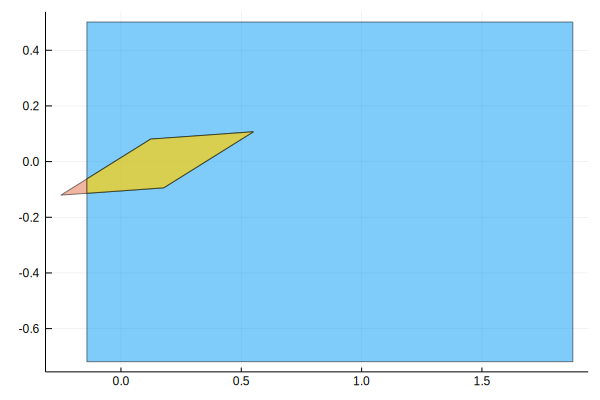

In [6]:
plot!(ans, color=:yellow)

In [7]:
# naive implementation for the polygon area using
# Shoelace formula, cf. https://en.wikipedia.org/wiki/Shoelace_formula
# This is: https://github.com/JuliaReach/LazySets.jl/issues/2055
function area(X::LazySet{N}) where {N}
    @assert dim(X) == 2 "this function only applies to two-dimensional sets, " *
    "but the given set is $(dim(X))-dimensional"
    
    v = vertices_list(X)
    X = vcat([vi[1] for vi in v], v[1][1])
    Y = vcat([vi[2] for vi in v], v[1][2])

    m = length(v)
    acc = zero(N)
    @inbounds for i in 1:m
        acc += X[i]*Y[i+1] - X[i+1]*Y[i]
    end
    return abs(acc/2)
end

area (generic function with 1 method)

In [8]:
area(C)

0.07349926719916536

In [9]:
using BenchmarkTools

In [10]:
@btime area(intersection($A, $B))

  113.339 μs (772 allocations: 71.59 KiB)


0.07349926719916536

---

In [11]:
"""

### Notes

The quadrilateral case is obtained by Shoelace formula for `m = 4` and factoring
out the expressions for the `x` coordinates.
"""
function area_v2(X::LazySet{N}) where {N}
    @assert dim(X) == 2 "this function only applies to two-dimensional sets, " *
    "but the given set is $(dim(X))-dimensional"
    
    v = vertices_list(X)
    m = length(v)
    
    if 0 <= m <= 2
        return zero(N)
    end
    
    if m == 3 # triangle
        A = v[1]
        B = v[2]
        C = v[3]
        res = A[1] * (B[2] - C[2]) + B[1] * (C[2] - A[2]) + C[1] * (A[2] - B[2])

    elseif m == 4 # quadrilateral
        A = v[1]
        B = v[2]
        C = v[3]
        D = v[4]
        res = A[1] * (B[2] - D[2]) + B[1] * (C[2] - A[2]) + C[1] * (D[2] - B[2]) + D[1] * (A[2] - C[2])
    
    else # general case

        # general case
        m = length(v)
        res = zero(N)
        for i in 1:m-1
            @inbounds res += v[i][1] * v[i+1][2] - v[i+1][1] * v[i][2]
        end
        @inbounds res += v[m][1] * v[1][2] - v[1][1] * v[m][2]

    end

    return abs(res/2)
end

area_v2

In [12]:
p = rand(VPolygon, num_vertices=4);

In [13]:
@btime area($p)

  2.131 μs (42 allocations: 1.88 KiB)


0.32201996083087325

In [14]:
@btime area_v2($p)

  6.125 ns (0 allocations: 0 bytes)


0.32201996083087314

In [15]:
area_v2()

MethodError: MethodError: no method matching area_v2()
Closest candidates are:
  area_v2(!Matched::LazySet{N}) where N at In[11]:9

In [16]:
p = VPolygon([[13, 14.], [16, 30.], [50, 10.]])

VPolygon{Float64,Array{Float64,1}}(Array{Float64,1}[[50.0, 10.0], [16.0, 30.0], [13.0, 14.0]])

In [17]:
@btime area($p)

  2.111 μs (42 allocations: 1.84 KiB)


302.0

In [18]:
@btime area_v2($p)

  5.888 ns (0 allocations: 0 bytes)


302.0

In [19]:
@btime area($C)

  7.158 μs (154 allocations: 8.53 KiB)


0.07349926719916536

In [20]:
v = VPolygon(vertices_list(C));

In [21]:
@btime area_v2($v)

  8.972 ns (0 allocations: 0 bytes)


0.07349926719916536

In [22]:
@btime area($v)

  2.120 μs (42 allocations: 1.91 KiB)


0.07349926719916536

In [23]:
  X[1]*Y[2] - X[2]*Y[1]
+ X[2]*Y[3] - X[3]*Y[2]
+ X[3]*Y[4] - X[4]*Y[3]
+ X[4]*Y[5] - X[5]*Y[4]

UndefVarError: UndefVarError: X not defined

In [24]:
  A[1]*B[2] - B[1]*A[2]
+ B[1]*C[2] - C[1]*B[2]
+ C[1]*D[2] - D[1]*C[2]
+ D[1]*A[2] - A[1]*D[2]

MethodError: MethodError: no method matching getindex(::Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}, ::Int64)

In [25]:
# TRIANGLE
  A[1]*B[2] - B[1]*A[2]
+ B[1]*C[2] - C[1]*B[2]
+ C[1]*A[2] - A[1]*C[2]

MethodError: MethodError: no method matching getindex(::Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}, ::Int64)

---

In [6]:
using Revise, LazySets, Test, BenchmarkTools

In [5]:
p = VPolygon([[13, 14.], [16, 30.], [50, 10.]])
@test area(p) ≈ 302.0

Test Passed

In [9]:
p = Interval(0.0, 1.0) × Interval(0.0, 0.0)

CartesianProduct{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}},Interval{Float64,IntervalArithmetic.Interval{Float64}}}(Interval{Float64,IntervalArithmetic.Interval{Float64}}([0, 1]), Interval{Float64,IntervalArithmetic.Interval{Float64}}([0, 0]))

In [10]:
area(p)

0.0

In [3]:
@test_throws ArgumentError area(p)

Test Passed
      Thrown: ArgumentError

In [ ]:
# error for higher-dimensional sets
p = BallInf(zeros(4), 1.0)
@test_throws ArgumentError area(p)

# triangle
p = VPolygon([[13, 14.], [16, 30.], [50, 10.]])
@test area(p) ≈ 302.0

# quadrilateral
p = VPolygon()
@test area(p) ≈ 302.0

# general case
p = VPolygon([[13, 14.], [16, 30.], [50, 10.]])
@test area(p) ≈ 302.0


In [12]:
# not implemented for dimension >= 3
p = BallInf(zeros(3), 1.0)
@test_throws ArgumentError area(p)

# sets with zero area
p = Singleton([0.0, 1.0])
@test area(p) ≈ 0.0
p = Interval(0.0, 1.0) × Interval(0.0, 0.0)
@test area(p) ≈ 0.0

Test Passed

In [13]:
# triangle
p = VPolygon([[13, 14.], [16, 30.], [50, 10.]])
@test area(p) ≈ 302.0

Test Passed

In [14]:


# quadrilateral, convex

# quadrilateral, non-convex

# general case, non-convex
vlist = [[3, 4.], [5, 11.], [12, 8.], [9, 5.], [5, 6.]]
p = VPolygon(vlist)

VPolygon{Float64,Array{Float64,1}}(Array{Float64,1}[[3.0, 4.0], [9.0, 5.0], [12.0, 8.0], [5.0, 11.0]])

In [15]:
VPol

35.0

In [17]:
LazySets._area_2D(vlist)

30.0

In [ ]:

@test area(p) ≈

# general case, convex
@test _area_2D(vlist) ≈ 30.0


In [19]:
# not implemented for dimension >= 3
p = BallInf(zeros(3), 1.0)
@test_throws ArgumentError area(p)

# sets with zero area
p = Singleton([0.0, 1.0])
@test area(p) ≈ 0.0
p = Interval(0.0, 1.0) × Interval(0.0, 0.0)
@test area(p) ≈ 0.0

# triangle
p = VPolygon([[13, 14.], [16, 30.], [50, 10.]])
@test area(p) ≈ 302.0

# quadrilateral
vlist = [[3, 4.], [5, 11.], [12, 8.], [9, 5.], [5, 6.]]
p = VPolygon(vlist) # convex hull => 5 points
@test area(p) ≈ 35.0

# general case (non-convex)
@test LazySets._area_2D(vlist) ≈ 30.0


Test Passed

In [23]:
p = rand(VPolygon, num_vertices=100)

VPolygon{Float64,Array{Float64,1}}(Array{Float64,1}[[-2.1716305634061936, 1.3533534658159798], [-2.1617264781696623, 0.9347763213346996], [-2.1485773599260947, 0.7918294668598922], [-2.0955644626574244, 0.4338847466886091], [-2.0455552396138037, 0.2158187539135939], [-2.0226724247692167, 0.1269736522447692], [-2.0175510131159524, 0.10829877581420233], [-1.9986122296219926, 0.0501622222691912], [-1.954698008833036, -0.07885418429794161], [-1.93346237988619, -0.1386467792563459]  …  [-1.894755167028802, 2.36946919267108], [-1.9551793455069877, 2.242748446662687], [-1.9955313526147642, 2.157064827888017], [-2.029012878292278, 2.0719877432250087], [-2.047933065855508, 2.0182951434194454], [-2.11049668987979, 1.8096203154413866], [-2.1506805695237525, 1.6115980935820018], [-2.156593973562573, 1.55448825341806], [-2.1686034163934313, 1.4199927027697579], [-2.1699100121203996, 1.392863072550406]])

In [24]:
length(p.vertices)

100

In [25]:
area(p)

17.136004882375886

In [27]:
@btime area($p)

  113.050 ns (0 allocations: 0 bytes)


17.136004882375886

## Faster intersection using HPolygon

In [2]:
using Revise, LazySets, BenchmarkTools, Plots

┌ Info: Precompiling LazySets [b4f0291d-fe17-52bc-9479-3d1a343d9043]
└ @ Base loading.jl:1273


In [10]:
# this function was missing, it is now https://github.com/JuliaReach/LazySets.jl/issues/2066
function Base.convert(::Type{HalfSpace{N, Vector{N}}},
                      hs::HalfSpace{N, LazySets.Arrays.SingleEntryVector{N}}) where {N}
    return HalfSpace(Vector(hs.a), hs.b)
end

# the idea is to use the intersection for HPolygon, which is faster than the fallback because the
# normal vectors to the half-spaces are sorted in counter--clockwise fashion 
function intersection_area(X::AbstractHyperrectangle{N},
                           Y::LinearMap{N, <:AbstractHyperrectangle{N}}) where {N}
    X_clist = X |> constraints_list
    X_poly = HPolygon(X_clist, sort_constraints=true, prune=false, check_boundedness=false)
    
    Y_clist = linear_map(Y.M, Y.X) |> constraints_list
    Y_poly = HPolygon(Y_clist, sort_constraints=true, prune=false, check_boundedness=false)

    return intersection(X_poly, Y_poly) |> area
end

intersection_area (generic function with 1 method)

### Test

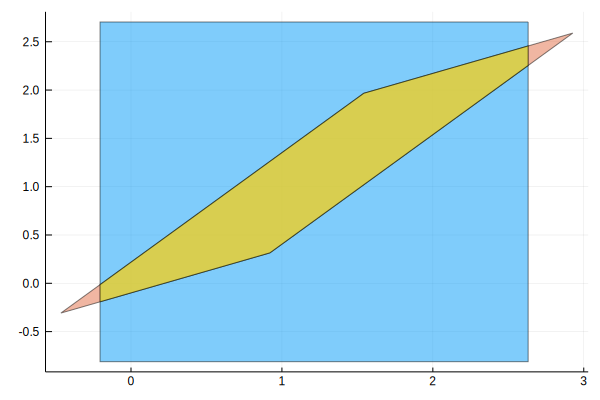

In [5]:
A = rand(Hyperrectangle)
B = rand(2, 2) * A
C = intersection(A, B)

plot([A, B])
plot!(C, color=:yellow)

In [6]:
# fallback
@btime area(intersection($A, $B))

  113.550 μs (764 allocations: 71.61 KiB)


1.8478516201871535

In [11]:
# new function
@btime intersection_area($A, $B)

  17.438 μs (360 allocations: 38.80 KiB)


1.8478516201871535